# Tobit Regression

Tobit is a special kind of regression for data that is somehow sensored. You could use some kind of survival analysis on this data, but that relies on the assumption that the treatment does not effect the probability of survival. This will become clearer as we work through an example.

An example of data on this could be exam results. This is the toy scenario that I will look at. Students at a univercity take a maths exam in year one. The exam is really really hard and no-one recieves 100% in this exam. There are some easy questions, so no-one recieves zero either. But the students complain and the second year exam is much easier. Many of the students recieve full marks on this exam, so it does not fully uncover the ability of some of the better students. The result of the second exam is correlated with the first one, of course, but it is not entirely determined by it.

We will extend this example further later, but first we want to generate some data of this kind and look at it, and then investigate how we can do a regression of second year exam result on first year exam result.

In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

Make some fake data. I'll hard code some parameters for now, we can add them as arguements later if we need to.

In [294]:
def get_data(n):
    """
    Returns a data frame of lenth 'n' with first year exam results and second year exam results.
    """
    
    first_year = np.random.normal(50, 10, n)
    
    # A hypothetical result if it were not capped at 100
    second_year_hidden = first_year + 40 + np.random.normal(0, 10, n)
    second_year = np.array([min(x, 100) for x in second_year_hidden])
    
    df = pd.DataFrame(
        {'first_year': first_year,
         'second_year': second_year,
         'second_year_hidden': second_year_hidden
        }
    )
    
    return df

In [112]:
df = get_data(2000)

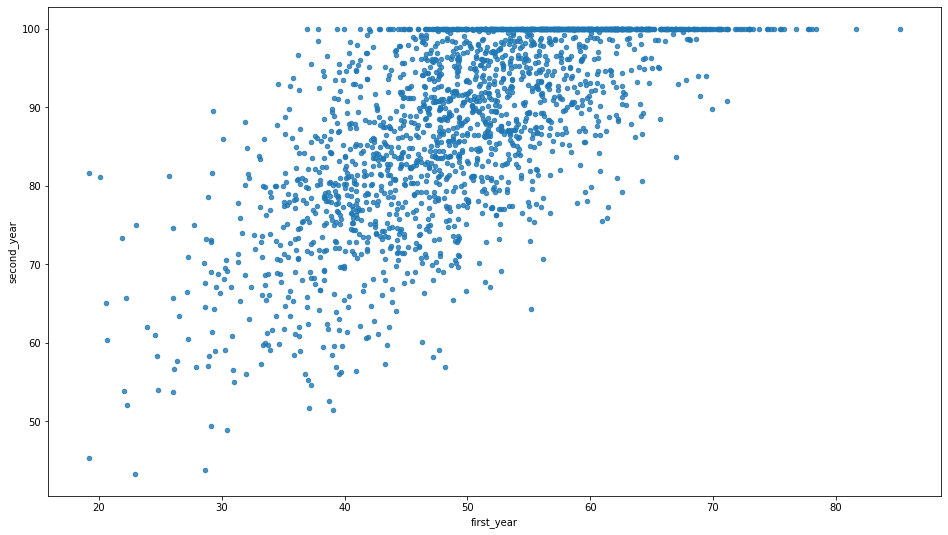

In [113]:
df.plot.scatter(x='first_year', y='second_year', figsize=(16, 9), alpha=0.8)

Now notice what is going on. There is a clear linear trend between x and y. However, the trend is sort of cut off beyond a certain point, and all the data is concentrated at the 100 mark. If we histogram y we see this clearly.

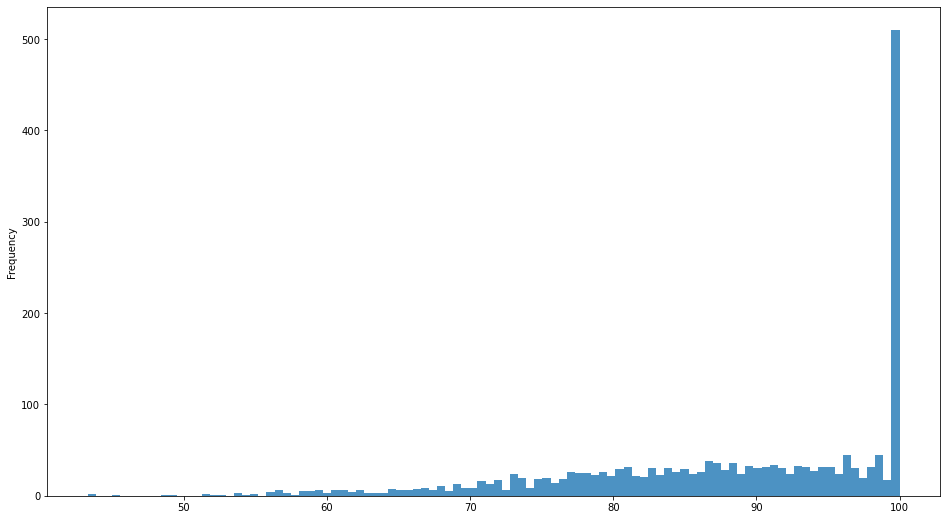

In [114]:
df.second_year.plot.hist(bins=100, figsize=(16, 9), alpha=0.8)

Now it's also instructive to look at the second year hidden variable. This is the hypothetical score that the student would have recieved if the exam was not capped at 100 (say if it had increasingly difficult questions after the main body of the exam. In reality we don't have access to this data, we only 'pretend' that it exists. Nonetheless, let's look at it.

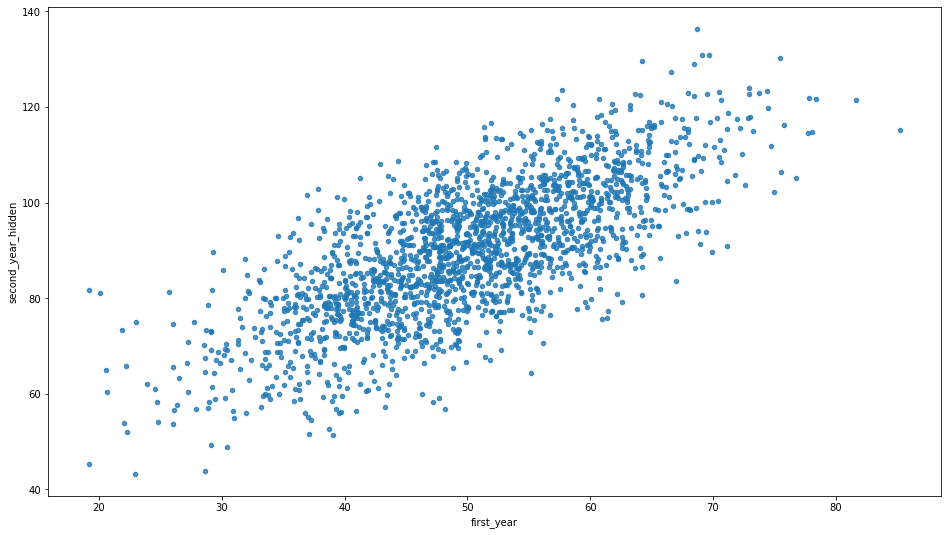

In [115]:
df.plot.scatter(x='first_year', y='second_year_hidden', figsize=(16, 9), alpha=0.8)

It's quite a clear linear relationship, albeit with some noise. We know this because we made up the data.

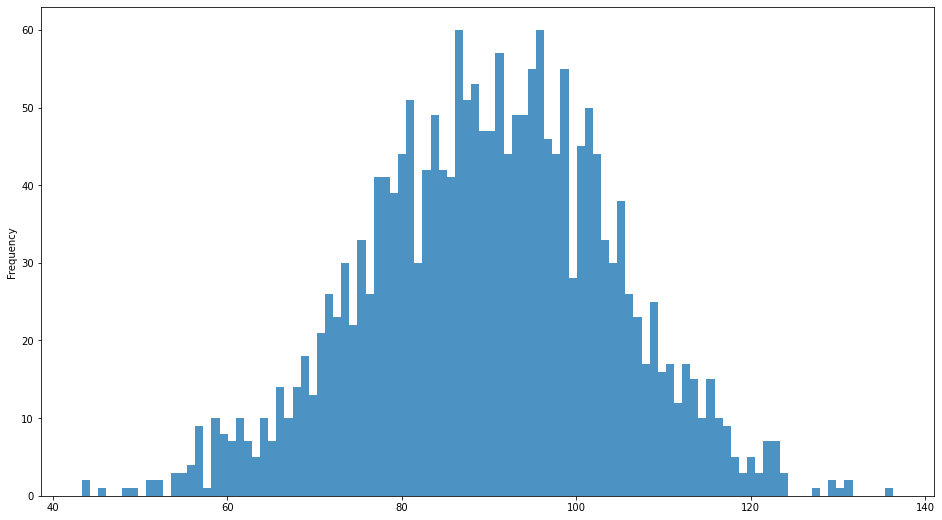

In [116]:
df.second_year_hidden.plot.hist(bins=100, figsize=(16, 9), alpha=0.8)

And the distribution of this data looks roughly normal.

The question now is: what kind of regression would work best between first year and second year results. Let's say that some of the students missed their second year exam and we want the best prediction of what their result would have been if they had taken it.

### Possible regressions

This first obvious approach is simply to run a regression on the entirety of the data. Let's try this.

In [117]:
import statsmodels.formula.api as smf

In [118]:
lr = smf.ols(formula='second_year ~ first_year', data=df)
fit = lr.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            second_year   R-squared:                       0.470
Model:                            OLS   Adj. R-squared:                  0.469
Method:                 Least Squares   F-statistic:                     1769.
Date:                Wed, 15 Dec 2021   Prob (F-statistic):          1.92e-277
Time:                        15:45:31   Log-Likelihood:                -7089.2
No. Observations:                2000   AIC:                         1.418e+04
Df Residuals:                    1998   BIC:                         1.419e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     47.7640      0.976     48.936      0.000      45.850      49.678
first_year     0.8047      0.019     42.060      0.000       0.767       0.842
==============================================================================
Omnibus:                       53.701   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               57.382
Skew:                          -0.408   Prob(JB):                     3.46e-13
Kurtosis:                       3.148   Cond. No.                         266.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

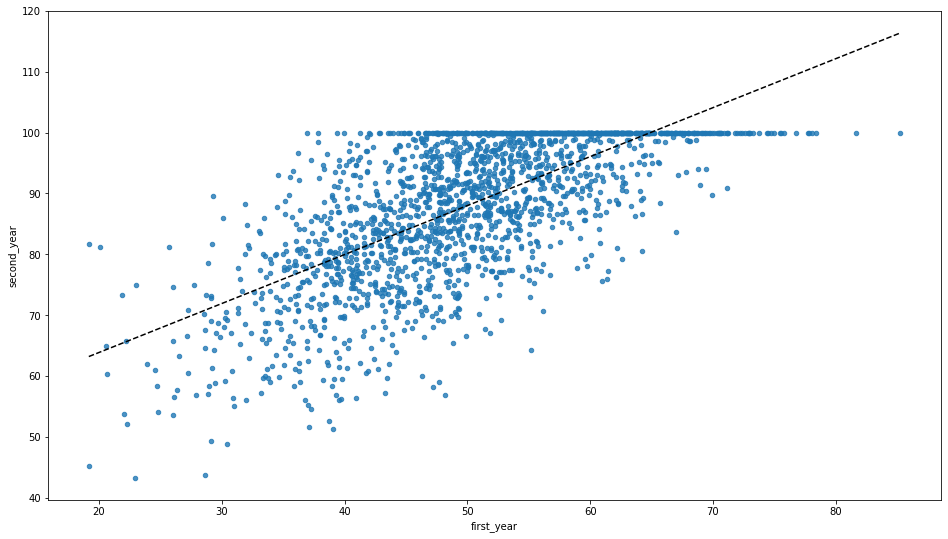

In [119]:
x = df.first_year.min(), df.first_year.max()
def model1(x):
    return fit.params.Intercept + fit.params.first_year*x
y = [model1(xx) for xx in x]
ax = df.plot.scatter(x='first_year', y='second_year', figsize=(16, 9), alpha=0.8)
ax.plot(x, y, '--', color='black')

Notice that the fitted line is not crazy, it does indeed capture some of the variation, but it over shoots at the beggining, it does this to try to compensate for the bunched up points towards the end. What it then does is predict values above 100, which we know is not possible. This might be what you are looking for, and it is indeed the straight line that minimises the squared error given the constraint of a straight line.

Let's also add the predictions of this model to our dataframe, so that we can compare various models as we go along.

In [120]:
df['ols_predictions'] = fit.predict()

In [121]:
ols_mse = ((df.ols_predictions - df.first_year) ** 2).mean()
ols_mse

1446.4185017801044

As an asside, what happens if we cut this line of best fit at 100, does that do a better job. You would imagine it would.

In [122]:
def model1b(x):
    return min(100, model1(x))

df['ols_capped_predictions'] = df.first_year.apply(model1b)
df

,first_year,second_year,second_year_hidden,ols_predictions,ols_capped_predictions
0,40.016956,79.740494,79.740494,79.964249,79.964249
1,52.254036,82.766783,82.766783,89.810988,89.810988
2,36.784981,80.683154,80.683154,77.363594,77.363594
3,56.468810,92.691923,92.691923,93.202465,93.202465
4,37.595930,67.528468,67.528468,78.016135,78.016135
...,...,...,...,...,...
1995,36.095370,80.764018,80.764018,76.808689,76.808689
1996,64.396328,94.826060,94.826060,99.581454,99.581454
1997,46.592030,100.000000,101.721231,85.254974,85.254974
1998,47.277744,78.655144,78.655144,85.806744,85.806744


In [123]:
((df.ols_capped_predictions - df.first_year) ** 2).mean()

1433.7274728398154

### Approach 2

What if we do a regression on only the data that is not 100, then if this line is more than 100 we cap it at that.

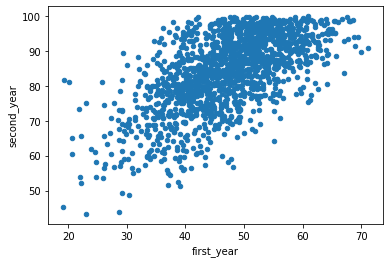

In [124]:
df_cut = df.query('second_year < 100')
df_cut.plot.scatter('first_year', 'second_year')

Let's make a line of fit to this data now.

In [125]:
lr = smf.ols(formula='second_year ~ first_year', data=df_cut)
fit = lr.fit()

And make the line of best fit. We could be clever and work out where this line cuts 100 and then compose the prediction out of two lines, but let's just predict for a large line of xs. Remember, we take this line so long as it is less than 100, otherwise we chuck out the prediction of 100.

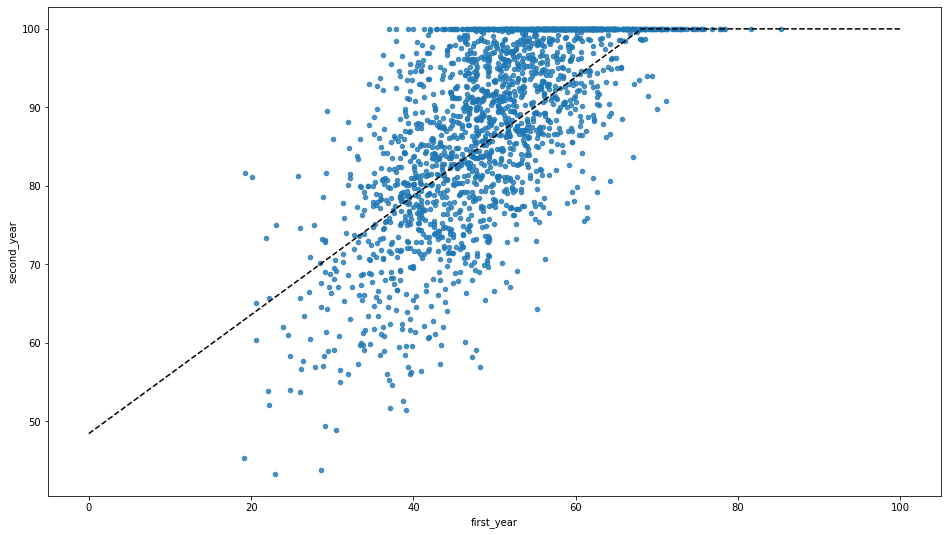

In [126]:
x = np.linspace(0, 100, 1001)
def model2(xx):
    return min(100, fit.params.Intercept + fit.params.first_year*xx)
y2 = [model2(xx) for xx in x]
ax = df.plot.scatter(x='first_year', y='second_year', figsize=(16, 9), alpha=0.8)
ax.plot(x, y2, '--', color='black')

In [127]:
df['model2_predictions'] = df.first_year.apply(model2)

In [128]:
((df.model2_predictions -  df.first_year) ** 2).mean()

1316.7476843403617

It's a little bit better, but only a bit.

So to summarise, the naive OLS was the worst performing. If we cut this at 100 then it does a bit better. It's better yet if we regress on the data that is not cut, and then extrapolate this and cap it at 100. However, it still seems like we can do a bit better, because this is not making use of the capped data at all. Let's dig into this in the next section.

### Interlude: The cheat

What if we cheat and we use the hidden variable directly. This is of course impossible in the real world, but it could be instructive. Would it be better at predicting the data. Let's find out.

I'm still going to truncate at 100, but the difference is that I have more data on which to estimate the underlying linear model. Let's try this.

In [129]:
lr = smf.ols(formula = 'second_year_hidden ~ first_year', data=df)
fit = lr.fit()

def model3a(x):
    return fit.params.Intercept + fit.params.first_year*x

def model3b(x):
    return min(100, model3a(x))

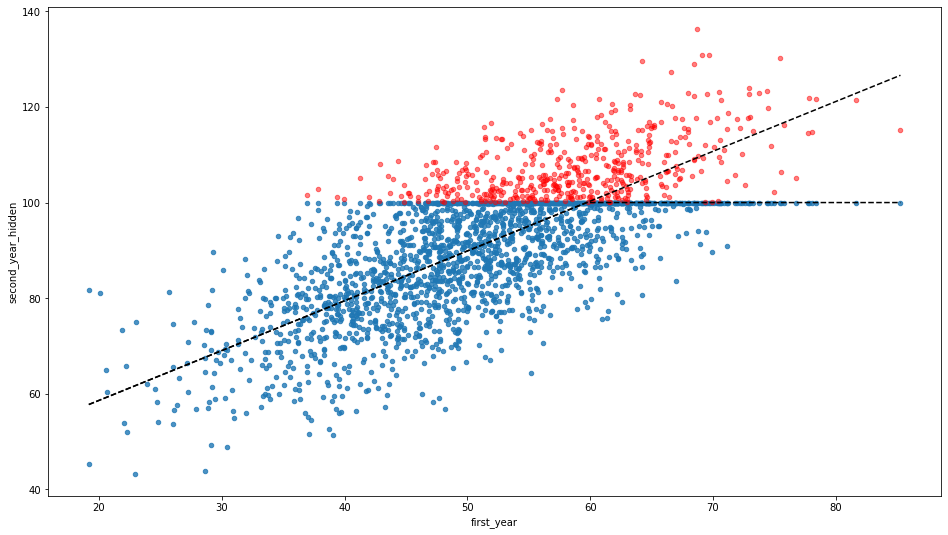

In [130]:
ax = df.plot.scatter('first_year', 'second_year', figsize=(16, 9), alpha=0.8)
df.query('second_year_hidden > 100').plot.scatter('first_year', 'second_year_hidden',
                                                  ax=ax, color='red', alpha=0.5)
x = np.linspace(df.first_year.min(), df.first_year.max(), 1001)
y1 = [model3a(xx) for xx in x]
y2 = [model3b(xx) for xx in x]

plt.plot(x, y1, '--', color='black')
plt.plot(x, y2, '--', color='black')

It looks a bit better to eyeball, but is it actually better?

In [131]:
df['prediction_model3a'] = df.first_year.apply(model3a)
df['prediction_model3b'] = df.first_year.apply(model3b)

In [132]:
((df.prediction_model3a - df.first_year)**2).mean()

1590.5950411656106

In [133]:
((df.prediction_model3b - df.first_year)**2).mean() 

1529.2788587441632

Actually this is a worse predictor! I guess because the other model is concentrated on the data that we are actually trying to predict in the end, whereas this also accomodates extra data? Could that be the case?

### Tobit Regression

Let's try this. It uses some MLE method to minimise some function. This is quite complicated in the end.

The tobit regression gives us a formular for the expected value of y given any x, and expresses this in terms of the normal distribution and the CDF of that distribution.

It looks like this:

$$E(y|x) = x\beta\Phi(\frac{x\beta}{\sigma}) + \sigma\phi(\frac{x\beta}{\sigma})$$

Where $\phi$ is the normal distribution and $\Phi$ is its CDF.

In [134]:
from scipy.stats import norm

Now of course the issue is that we don't know either beta or sigma from the data. But because we made up the data ourselves we sort of do know these, so simply as a learning exercise I'm going to plot this funciton and see what it gives me.

One important rinkle is that the derivation assumed that the data was left censored at zero, our data is not, but of course we could make that transformation.

We could plot 100 - the data to get the standard setup.

In [162]:
df['y_trans'] =  (100 - df.second_year)

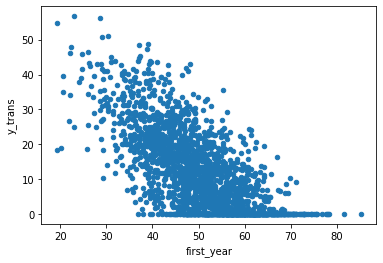

In [163]:
df.plot.scatter('first_year', 'y_trans')

In [150]:
def eyx(x, beta, sigma):
    return x*beta*norm.cdf(x*beta/sigma) + sigma* norm.pdf(x*beta/sigma)

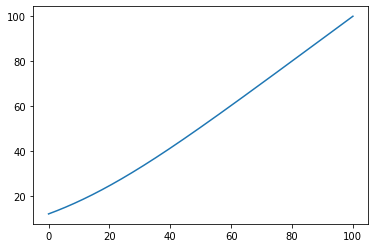

In [159]:
xs = np.linspace(0, 100, 1001)
ys = [eyx(x, 1, 30) for x in xs]

plt.plot(xs, ys)

The example I was using assumed no intercept, and left truncation at zero. So let's create fake data with this property as a first step.

In [186]:
def fake2(n, beta, sigma):
    x = np.linspace(-1, 1, n)
    ys = x*beta + np.random.normal(0, sigma, size=n)
    y = np.array([max(0, yy) for yy in ys])
    return pd.DataFrame({'x': x,
                         'y': y})

In [198]:
beta = 0.5
sigma = 0.1
df = fake2(1000, beta, sigma)

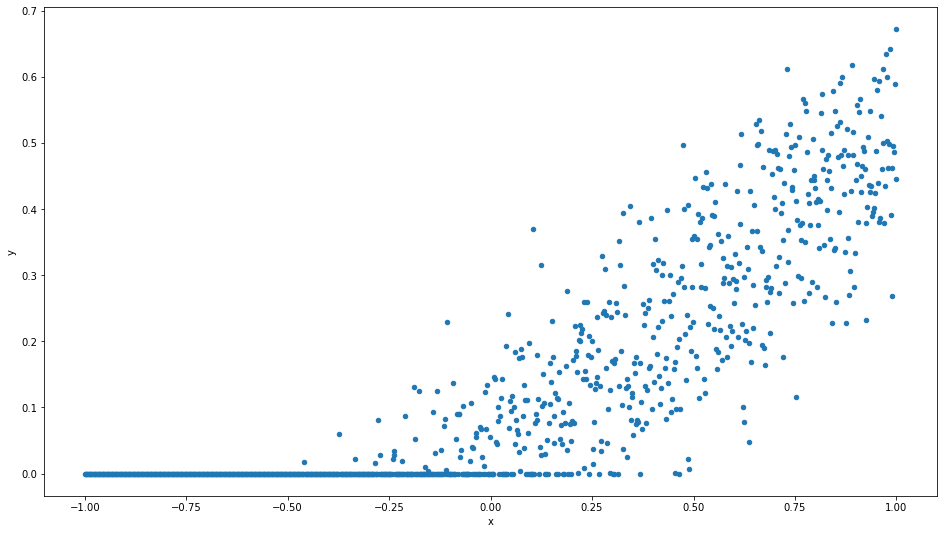

In [199]:
df.plot.scatter('x', 'y', figsize=(16, 9))

That fits the description of the assumptions, let's see if the formular that we have fits it (even though we are a prior assuming sigma and beta).

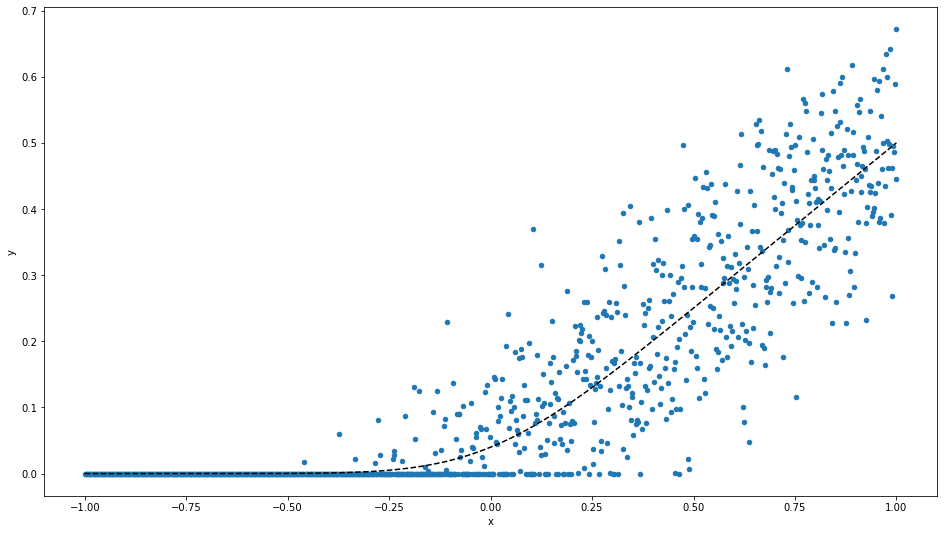

In [203]:
xs = np.linspace(-1, 1, 1001)
ys = [eyx(x, beta, sigma) for x in xs]

ax = df.plot.scatter('x', 'y', figsize=(16, 9))

ax.plot(xs, ys, '--', color='black')

That does indeed look to be the thing we are looking for. The only issue is that we havn't found a way to actually estimate beta and sigma. This comes from minimising log likelihood.

Let's code up the likelihood function as well as see if this works.

In [213]:
def ll_i(xi, yi, beta, sigma):
    if yi == 0:
        return np.log(1 - norm.cdf(xi*beta/sigma))
    else:
        return np.log(1/sigma*norm.pdf((yi-xi*beta)/sigma))

The above is for one point. Let's work out the sum of all these likelihoods (sum them as they are logs).

In [214]:
def ll(x, y, beta, sigma):
    return sum([ll_i(xi, yi, beta, sigma) for xi, yi in zip(x, y)])

Now let's test that this is roughly sensible. Give it my data, and tell it the correct answer for sigma, and plot for a variety of different betas. We should get the answer we were looking for.

In [215]:
betas = np.linspace(-1, 1, 101)
lls = [ll(df.x, df.y, b, sigma) for b in betas]

<ipython-input-213-60e1e2f32f28>:3: RuntimeWarning: divide by zero encountered in log
  return np.log(1 - norm.cdf(xi*beta/sigma))


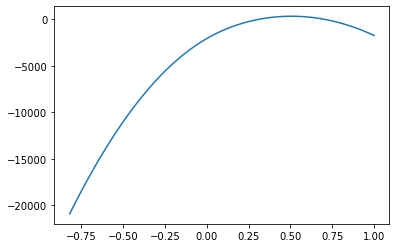

In [216]:
plt.plot(betas, lls)

That looks like it is about right. Let's also try the same for sigma.

In [218]:
sigma, beta

(0.1, 0.5)

In [221]:
sigmas = np.linspace(0, 1, 101)
lls = [ll(df.x, df.y, beta, s) for s in sigmas]

<ipython-input-213-60e1e2f32f28>:3: RuntimeWarning: divide by zero encountered in double_scalars
  return np.log(1 - norm.cdf(xi*beta/sigma))
<ipython-input-213-60e1e2f32f28>:5: RuntimeWarning: divide by zero encountered in double_scalars
  return np.log(1/sigma*norm.pdf((yi-xi*beta)/sigma))
<ipython-input-213-60e1e2f32f28>:5: RuntimeWarning: invalid value encountered in double_scalars
  return np.log(1/sigma*norm.pdf((yi-xi*beta)/sigma))
<ipython-input-213-60e1e2f32f28>:3: RuntimeWarning: divide by zero encountered in log
  return np.log(1 - norm.cdf(xi*beta/sigma))


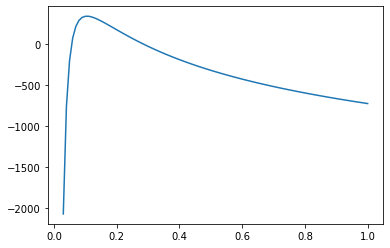

In [222]:
plt.plot(sigmas, lls)

So it seems that in principle this actually works. Now there are two remaining questions.

* What should we do when the censoring is right and not at zero. Derive a more general formular for this, or transform your data so that it has these properties.
* Is there a more efficient way to find the variables. Numeric minimisation? Or can we even do it in closed form?

Maybe we can tackle the textbook again, now that you have the context and a general understanding.

Quote from the textbook:

```
 The
log-likelihood for a random sample of size n is obtained by summing (17.22) across all i.
The maximum likelihood estimates of  and  are obtained by maximizing the loglikelihood; this requires numerical methods, although in most cases this is easily done
using a packaged routine.
```

So let's try to use a minimisation package to estimate these parameters.

#### Minimisation

Let's try to minimise the log-likelihood (actually maximise, but I'll add a negative sign to it).

The way I have written it is not too efficient, so I'll tweak it now to be a bit more vectory.

The first step is simply to write a function that returns a number, based on beta and sigma.

In [227]:
x = df.x

In [228]:
y = df.y

In [256]:
def ll_factory(x, y):
    
    zero_mask = [int(yy==0) for yy in y]
    non_zero_mask = [int(yy > 0) for yy in y]
    
    def ll(V):
        beta, sigma = V
        return - sum(zero_mask * np.log(1 - norm.cdf(x*beta/sigma))
         + non_zero_mask* np.log(1/sigma*norm.pdf((y-x*beta)/sigma)))
    
    return ll

In [257]:
ll = ll_factory(x, y)

And again sanity check this a bit.

<ipython-input-256-f5455904aff8>:8: RuntimeWarning: divide by zero encountered in log
  return - sum(zero_mask * np.log(1 - norm.cdf(x*beta/sigma))
<ipython-input-256-f5455904aff8>:8: RuntimeWarning: invalid value encountered in multiply
  return - sum(zero_mask * np.log(1 - norm.cdf(x*beta/sigma))


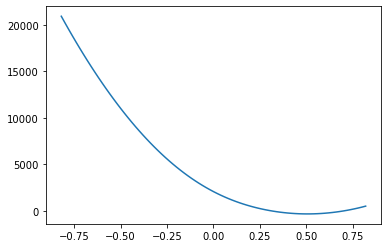

In [258]:
betas = np.linspace(-1, 1, 101)
sigma = 0.1
lls = [ll((b, sigma)) for b in betas]
ax = plt.plot(betas, lls)

Now we have our function, let's feed it to a minimisation routine.

In [259]:
from scipy.optimize import minimize

In [292]:
res = minimize(ll, (0, 0.5), method='nelder-mead',
               options={'xatol': 1e-8, 'disp': True})

Optimization terminated successfully.
         Current function value: -335.027348
         Iterations: 84
         Function evaluations: 162


<ipython-input-256-f5455904aff8>:8: RuntimeWarning: divide by zero encountered in log
  return - sum(zero_mask * np.log(1 - norm.cdf(x*beta/sigma))
<ipython-input-256-f5455904aff8>:8: RuntimeWarning: invalid value encountered in multiply
  return - sum(zero_mask * np.log(1 - norm.cdf(x*beta/sigma))


In [293]:
res.x

array([0.50714133, 0.1054409 ])

That's a bingo!

Those are indeed the values that we wanted. Problem solved. Of course this may not be the best of most efficient way of solving this problem, but it works.

#### Asside

What about the least squares method. What values would this give?

We have a function that fits our data, so we could do a least squared method on this data and try to fit the data. I'm curious if this would give the same (or roughly the same) values.

In [282]:
def mse_fadctory(x, y):
    
    def mse(V):
        beta, sigma = V
        predictions = eyx(x, beta, sigma)
        errors = predictions - y
        return (errors ** 2).sum()
    
    return mse

In [283]:
mse = mse_fadctory(df.x, df.y)

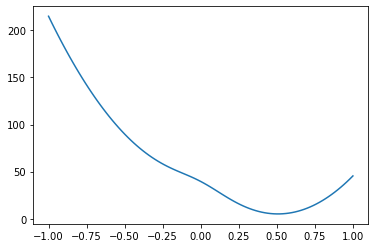

In [284]:
plt.plot(betas, [mse([b, 0.1]) for b in betas])

And do exactly the same thing here.

In [289]:
res = minimize(mse, (0, 0.5), method='nelder-mead',
               options={'xatol': 1e-12, 'disp': True})

Optimization terminated successfully.
         Current function value: 5.111585
         Iterations: 104
         Function evaluations: 218


In [290]:
res.x

array([0.50677183, 0.11945532])

These numbers are indeed quite close, although they seem to be further than the other method.

That solves the problem.

### Transforming data

Our oringinal problem was actually right cencored, and not at zero. How do we transform this data so that it is? Or alternatively, is there a more general form of these equations.

In [296]:
df = get_data(2000)
df.head()

,first_year,second_year,second_year_hidden
0,44.586264,98.189453,98.189453
1,66.404457,96.583338,96.583338
2,54.812702,88.472375,88.472375
3,46.520586,69.502680,69.502680
4,60.826223,100.000000,100.147410


In [345]:
df['x'] = - df.first_year
df['y'] = 100 - df.second_year

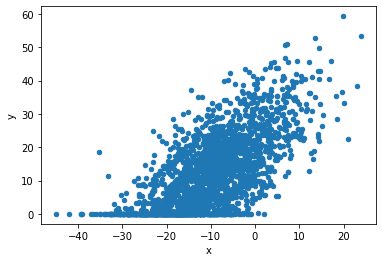

In [342]:
df.plot.scatter('x', 'y')

And now let's see what value of beta and sigma I would get from this, and how this relates to what I had to begin with.

In [343]:
ll = ll_factory(df.x, df.y)
res = minimize(ll, (1, 5), method='nelder-mead',
               options={'xatol': 1e-12, 'disp': True})
beta, sigma = list(res.x)
beta, sigma

Optimization terminated successfully.
         Current function value: 7069.823389
         Iterations: 101
         Function evaluations: 219


(0.11778910891192017, 19.149869227340858)

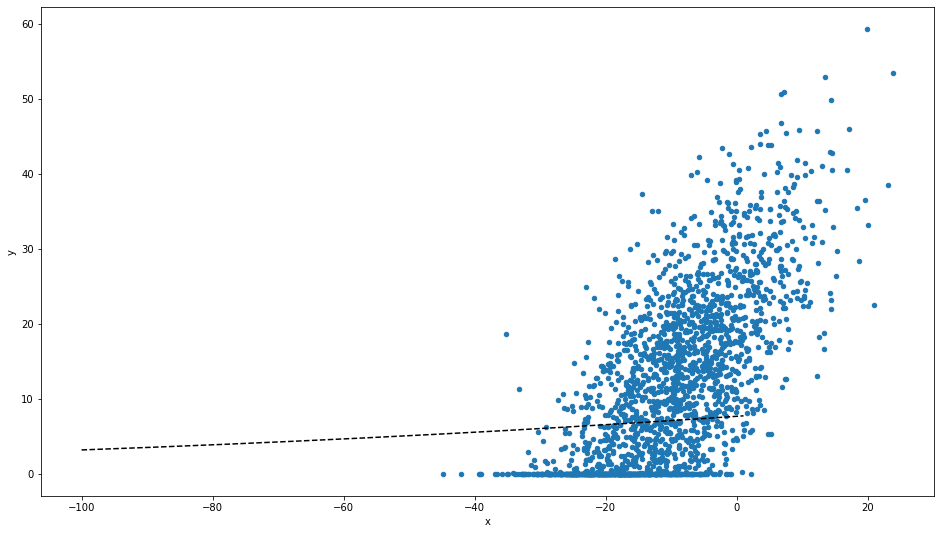

In [344]:
xs = np.linspace(-100, 1, 1001)
ys = [eyx(x, beta, sigma) for x in xs]

ax = df.plot.scatter('x', 'y', figsize=(16, 9))

ax.plot(xs, ys, '--', color='black')

### Other topics

* Fitting an intercept.
* Computing t (and p) values
* Binary independent variable
* Partial effects? (see the economics textbook).